# Basics of Neural Networks

In [ ]:
import numpy as np
import torch 
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline 

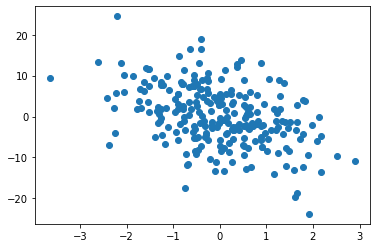

In [3]:
data = np.random.multivariate_normal([0,0],[[1,-3],[-3,52]],250)
X = torch.tensor(data[:,0]).type(torch.FloatTensor)
y = torch.tensor(data[:,1]).type(torch.FloatTensor)
plt.scatter(X,y)


## Linear model

We will focus on a linear model of the form $y = w_0 + w_1x + \epsilon$. Where $\epsilon$ is assumed to be gaussian noise with zero mean and variance $\sigma^2$.


**Analytic solution**

w: tensor([ 0.0891, -2.8788])


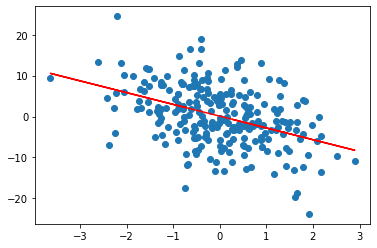

In [4]:
X_ = torch.cat((torch.ones(X.size()).unsqueeze(dim=1),X.unsqueeze(dim=1)),1)
w = torch.inverse(X_.T @ X_) @ X_.T @ y
print('w:',w)
plt.plot(X, X_ @ w,'r')
plt.scatter(X,y)

### Gradient descent
**Gradient descent with pytorch autograd**

In [5]:
def r_emp(w,X,y):
     return (y - X @ w).T @ (y - X @ w)

In [6]:
def min_r_emp_1(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    
    for i in range(k):
        if w.grad is not None:
            w.grad.zero_()
        l_p = r_emp(w,X,y)
        l_p.backward()
        w = (w - lr*w.grad).detach().requires_grad_()
    return w

In [7]:
w_g = min_r_emp_1(X_,y)
print('Solution: ',w_g)

Solution:  tensor([ 0.0891, -2.8788], requires_grad=True)


C:\Users\dohr\AppData\Local\Temp\ipykernel_18624\2613419657.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2985.)
  return (y - X @ w).T @ (y - X @ w)


**Gradient descent with pytorch autograd and optimizer**

In [8]:
def min_r_emp_2(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    optimizer = optim.SGD([w],lr=lr)
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        optimizer.zero_grad()
        l_p.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l_p))
    return w

In [9]:
w_g_2 = min_r_emp_2(X_,y,lr=0.001,k=500)
print('Solution:',w_g_2)

Epoch 0, Loss 15472.895508
Epoch 100, Loss 10954.540039
Epoch 200, Loss 10954.540039
Epoch 300, Loss 10954.540039
Epoch 400, Loss 10954.540039
Solution: tensor([ 0.0891, -2.8788], requires_grad=True)


**Gradient descent with manual differentiation**

In [10]:
def dw_r_emp(w,X,y):
    return X.T @ (X @ w - y)

In [11]:
def min_r_emp_3(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1])
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        dw = dw_r_emp(w,X,y)
        w = (w - lr*dw)
    return w

In [12]:
w_g_3 = min_r_emp_3(X_,y,lr=0.001,k=500)
print('Solution:',w_g_3)

Solution: tensor([ 0.0891, -2.8788])


Define a general training loop

In [13]:
def training_loop(X,y,w,optimizer,model,loss_fn,lr=1e-3,n_epochs=5000):
   
    for i in range(n_epochs):
        y_p = model(w,X)
        loss = loss_fn(y_p,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,loss))

    print('Result:',w)
    return w

In [14]:
def model(w,X):
    return X @ w

def loss_fn(y_p,y):
    return 0.5*((y_p - y)**2).sum()

In [16]:
w = torch.ones(X_.shape[1],requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

training_loop(X_,y,w,optimizer,model,nn.MSELoss())

Epoch 0, Loss 61.891590
Epoch 500, Loss 45.668804
Epoch 1000, Loss 44.011040
Epoch 1500, Loss 43.838703
Epoch 2000, Loss 43.820400
Epoch 2500, Loss 43.818409
Epoch 3000, Loss 43.818188
Epoch 3500, Loss 43.818165
Epoch 4000, Loss 43.818157
Epoch 4500, Loss 43.818157
Result: tensor([ 0.0892, -2.8787], requires_grad=True)


tensor([ 0.0892, -2.8787], requires_grad=True)

## Perceptron

generate 2-D testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_18624\2996375989.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


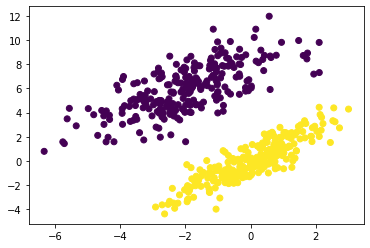

In [75]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,6],[[2,2],[2,4]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2),0)
y = torch.cat((torch.ones(250),torch.ones(250)*(-1)),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [83]:
def model_perc(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.sign(x_temp @ w)

In [87]:
def loss_perc(y_p,y):
    mask = (y_p * y) == -1
    return mask.sum()

In [97]:
def train_loop_perc(X,y,lr=1e-3,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
    print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_perc(X,w)
        l = loss_perc(y_p,y)
        print(l)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad).detach().requires_grad()

    return w

In [98]:
train_loop_perc(X,y)

tensor([1., 1., 1.], requires_grad=True)
tensor(330)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [94]:
y.sum()

tensor(0.)